In [1]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from matplotlib import pyplot
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import pathlib
# from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

print(tf.__version__)
print(tf.config.list_physical_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.5.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [2]:
x_voc = 8440
y_voc = 1989

In [3]:
# load the weights
w_encoder_embeddings = np.load('model/enc_embedding.npz', allow_pickle=True)
w_decoder_embeddings = np.load('model/dec_embedding.npz', allow_pickle=True)
w_encoder_lstm0 = np.load('model/encoder_lstm0.npz', allow_pickle=True)
w_encoder_lstm1 = np.load('model/encoder_lstm1.npz', allow_pickle=True)
w_decoder_lstm = np.load('model/lstm_2.npz', allow_pickle=True)
time_distributed  = np.load('model/time_distributed.npz', allow_pickle=True)

In [4]:
# Bidirectional LSTM
K.clear_session()

latent_dim = 300
embedding_dim = 100

# Encoder
encoder_inputs = Input(shape=(None,))

# embedding layer
enc_emb =  Embedding(63320, 100, trainable=True, name = "enc_embedding")(encoder_inputs)


encoder_lstm0 = Bidirectional(
    LSTM(latent_dim, return_sequences=True),
    name = 'encoder_lstm0')
encoder_outputs0 = encoder_lstm0(enc_emb)

encoder_lstm1 = Bidirectional(
    LSTM(latent_dim, return_state=True),
    name = 'encoder_lstm1')
encoder_outputs, enc_forward_h, enc_forward_c, enc_backward_h, enc_backward_c  = encoder_lstm1(encoder_outputs0)


state_h = Concatenate()([enc_forward_h, enc_backward_h])
state_c = Concatenate()([enc_forward_c, enc_backward_c])
encoder_states = [state_h, state_c]
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(14856, 100,trainable=True, name = 'dec_embedding')
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0)
decoder_outputs1, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)

# Attention layer
attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([decoder_outputs1, encoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs1, attn_out])

#dense layer
decoder_dense = TimeDistributed(Dense(14856, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_embedding (Embedding)       (None, None, 100)    6332000     input_1[0][0]                    
__________________________________________________________________________________________________
encoder_lstm0 (Bidirectional)   (None, None, 600)    962400      enc_embedding[0][0]              
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [5]:
# set the weights of the model

model.layers[1].set_weights(w_encoder_embeddings['arr_0'])
model.layers[2].set_weights(w_encoder_lstm0['arr_0'])
model.layers[4].set_weights(w_encoder_lstm1['arr_0'])
model.layers[5].set_weights(w_decoder_embeddings['arr_0'])
model.layers[8].set_weights(w_decoder_lstm['arr_0'])
model.layers[11].set_weights(time_distributed['arr_0'])

In [6]:
import pickle
# load the tokenizer
with open('model/x_tokenizer.pickle', 'rb') as handle:
    x_tokenizer = pickle.load(handle)
with open('model/y_tokenizer.pickle', 'rb') as handle:
    y_tokenizer = pickle.load(handle)
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [7]:
#bidirectional
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(latent_dim*2))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])

decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

https://stackoverflow.com/questions/70128813/how-do-i-save-an-encoder-decoder-model-with-tensorflow

In [113]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0) 

def top_k_sampling(predictions, k):
    top_k_probabilities, top_k_indices= tf.math.top_k(predictions, k=k, sorted=True)
    top_k_indices = np.asarray(top_k_indices).astype("int32")
    top_k_redistributed_probability=softmax(np.log(top_k_probabilities))
    top_k_redistributed_probability = np.asarray(top_k_redistributed_probability).astype("float32")
    sampled_token = np.random.choice(top_k_indices, p=top_k_redistributed_probability)
#     print(reverse_target_word_index[sampled_token])
#     top_k_tokens=[dictionary[i] for i in top_k_indices]
#     plt.bar(top_k_tokens,top_k_redistributed_probability)
#     plt.show()
    return sampled_token

In [114]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        #sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token_index = top_k_sampling(output_tokens[0, -1, :],5)
        #sampled_token_index = np.random.choice(len(output_tokens[0, -1, :]), p=output_tokens[0, -1, :])
  
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [115]:
data=pd.read_csv(f"{pathlib.Path().resolve()}\\input\\cnn_dailymail\\test.csv", nrows=100)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          100 non-null    object
 1   article     100 non-null    object
 2   highlights  100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [116]:
data.drop_duplicates(subset=['article'],inplace=True) #dropping duplicates
data.dropna(axis=0,inplace=True) #dropping na

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          100 non-null    object
 1   article     100 non-null    object
 2   highlights  100 non-null    object
dtypes: object(3)
memory usage: 3.1+ KB


In [118]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [119]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString).text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if (num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1: # removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [120]:
#call the function
cleaned_text = []
for t in data['article']:
    cleaned_text.append(text_cleaner(t,0)) 

In [121]:
#call the function
cleaned_summary = []
for t in data['highlights']:
    cleaned_summary.append(text_cleaner(t,1))

In [122]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [123]:
#drop empty rows
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

Mean of Article Length 344.4
Mean of Summary Length 46.7


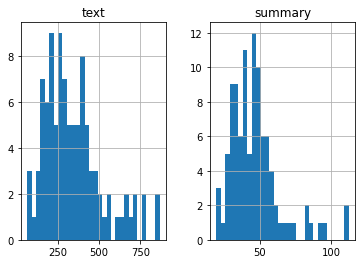

In [124]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
print('Mean of Article Length',sum(text_word_count)/len(text_word_count))
print('Mean of Summary Length',sum(summary_word_count)/len(summary_word_count))
length_df.hist(bins = 30)
plt.show()

In [125]:
max_text_len=400
max_summary_len=46

cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
#     if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
    short_text.append(cleaned_text[i])
    short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [126]:
#making sure tokens dont appear in the summaries
for summary in df['summary']:
    if 'sostok' in summary:
        print("ERROR")
    if 'eostok' in summary:
        print("ERROR")

In [127]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [128]:
x_val = df['text']
y_val = df['summary']

In [129]:
#bidirectional
for i in range(0,10):
    x_val_seq   =   x_tokenizer.texts_to_sequences([x_val[i]])
    x_val_i   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')
    
    y_val_seq   =   y_tokenizer.texts_to_sequences([y_val[i]])
    y_val_i   =   pad_sequences(y_val_seq, maxlen=max_text_len, padding='post')

    print("Article:",seq2text(x_val_i[0]))
    print("Original summary:",seq2summary(y_val_i[0]))
    print("Predicted summary:",decode_sequence(x_val_i[0].reshape(1,max_text_len)))
    print("\n")

Article: ever noticed plane seats appear getting smaller smaller increasing numbers people taking skies experts questioning packed planes putting passengers risk say shrinking space aeroplanes uncomfortable putting health safety danger squabbling arm rest shrinking space planes putting health safety danger week consumer advisory group set department transportation said public hearing government happy set standards animals flying planes stipulate minimum amount space humans world animals rights space food humans said charlie consumer representative committee time dot faa take stand humane treatment passengers could crowding planes lead serious issues fighting space overhead lockers crashing elbows seat back kicking tests conducted faa use planes inch pitch standard airlines decreased many economy seats united airlines inches room airlines offer little inches cynthia human factors researcher federal aviation administration conducts tests quickly passengers leave plane tests conducted usi

Predicted summary:  new york tv show is in one of the family in new york series show she will be to have the youngest time she has also been in the last and the family of the stars she says


Article: moment crew firefighters struggled haul giant pig garden swimming pool prize porker known fallen pool upmarket neighbourhood ringwood hampshire owners taking walk around garden animal plunged water unable get team dorset fire rescue struggled haul huge black pig swimming pool water prize porker known fallen water unable get two fire crews specialist animal rescue team use slide boards haul huge black pig small pool spokesman dorset fire rescue service said pm yesterday service received call pig stuck swimming pool one crew firefighters specialist animal rescue unit poole mobilised incident attendance crew secured pig requested attendance another appliance mobilised ringwood colleagues hampshire fire rescue service firefighters also called horse fallen swimming pool west sussex exhausted a

Predicted summary:  england beat wales at the rugby stadium on saturday night one of three players who were beaten by their side on their day in south africa they have now won the gold in the league series


Article: sentences three nine years jail jailed ahmed hassan sentenced nine years imprisonment mohamed saleh imprisoned four years nine months girls aged targeted gang parties organised ahmed hassan known one child described parties place girls would go boys would choose targets victims described court emotionally immature abused sentencing hassan others court packed friends relatives defendants victims yesterday judge zoe smith said put charity events raise money football club raised profile among young people banbury saw celebrity friends helped put events became sexually promiscuous group girlfriends girls young vulnerable lacking maturity judge rejected argument put forward defence accused girls coming forward better victim slag behind bars jailed four years said saleh sentence

In [130]:
print(x_val.shape)

(100,)
